In [2]:
import requests
from bs4 import BeautifulSoup
import csv
import time
from tabulate import tabulate
import sqlite3

# ランキングページ（2024年版）
RANKING_PAGE_URL = "https://onsen.nifty.com/rank/year/"
OUTPUT_FILE = "onsen_details.csv"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36"
    )
}

def fetch_page(url):
    """指定したURLからHTMLデータを取得し、BeautifulSoupオブジェクトを返す"""
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"[ERROR] Failed to fetch: {url}")
        print(e)
        return None
    return BeautifulSoup(response.text, "html.parser")

def extract_facility_urls(ranking_url):
    """
    ランキングページから 1位〜100位 に該当する温泉施設のURLを一覧で取得する。
    """
    soup = fetch_page(ranking_url)
    if not soup:
        return []

    # liタグで classに normal, small, mini が付いているものを抽出 (1〜100位)
    facility_li_list = soup.select("li.normal, li.small, li.mini")

    facility_urls = []
    for li in facility_li_list:
        a_tag = li.select_one("a[href]")
        if a_tag:
            href = a_tag.get("href")
            # onsen.nifty.comでは href はフルURLなのでそのまま格納
            if href.startswith("http"):
                facility_urls.append(href)
            else:
                # 万が一相対URLだったらフルURLに変換
                facility_urls.append("https://onsen.nifty.com" + href)

    # 重複排除してから先頭100件だけに絞る
    facility_urls = list(dict.fromkeys(facility_urls))
    return facility_urls[:100]

def scrape_facility_details(facility_url):
    """各温泉施設ページから詳細情報（効能など）を取得"""
    print(f"Fetching details from: {facility_url}")
    soup = fetch_page(facility_url)
    if not soup:
        return {
            "name": "N/A",
            "address": "N/A",
            "tel": "N/A",
            "features": "N/A",
            "benefits": "N/A",
        }

    def extract_text(selector):
        """soup.select_one(selector)からテキストを抜き出す簡易関数"""
        element = soup.select_one(selector)
        return element.text.strip() if element else "N/A"

    # 以下のセレクタはサンプルです。実際のHTML構造によっては取得できない場合があるため要調整。
    name = extract_text("th:contains('施設名') + td")
    address = extract_text("th:contains('住所') + td")
    tel = extract_text("th:contains('TEL') + td")
    features = extract_text("dt:contains('特徴') + dd")
    benefits = extract_text("dt:contains('効能') + dd")

    # 他にも「泉質」や「料金」など必要があれば同様の方法で抽出可能

    return {
        "name": name,
        "address": address,
        "tel": tel,
        "features": features,
        "benefits": benefits,
    }

def save_to_csv(all_facilities):
    """取得した温泉データをCSVに保存"""
    with open(OUTPUT_FILE, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["name", "address", "tel", "features", "benefits"]
        )
        writer.writeheader()
        writer.writerows(all_facilities)

def save_to_db(all_facilities):
    """取得した温泉データをSQLiteデータベースに格納"""
    # SQLiteファイルに接続 (無ければ新規作成される)
    conn = sqlite3.connect("onsen.db")
    cursor = conn.cursor()

    # テーブル作成 (なければ作る)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS onsen_facilities (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT,
            address TEXT,
            tel TEXT,
            features TEXT,
            benefits TEXT
        )
    """)

    # データをINSERT
    for fac in all_facilities:
        cursor.execute("""
            INSERT INTO onsen_facilities (name, address, tel, features, benefits)
            VALUES (?, ?, ?, ?, ?)
        """, (
            fac["name"],
            fac["address"],
            fac["tel"],
            fac["features"],
            fac["benefits"]
        ))
    conn.commit()
    conn.close()

def main():
    """温泉情報を取得してCSV・DBに保存し、コンソールにも出力するメイン処理"""
    # 1. ランキングページから温泉施設のURL一覧を取得
    onsen_urls = extract_facility_urls(RANKING_PAGE_URL)

    all_facilities = []

    # 2. 各施設ページへアクセスして詳細情報を取得 (サーバー負荷軽減のためtime.sleep)
    for url in onsen_urls:
        details = scrape_facility_details(url)
        all_facilities.append(details)
        time.sleep(1)  # サーバー負荷を軽減するために1秒ウェイト

    # 3. 抽出結果を表形式で表示
    print("\n--- スクレイピング結果（最大100件） ---")
    print(tabulate(all_facilities, headers="keys", tablefmt="grid"))

    # 4. CSVに保存
    save_to_csv(all_facilities)
    print(f"\n[INFO] Saved {len(all_facilities)} facilities to '{OUTPUT_FILE}'")

    # 5. DBに保存
    save_to_db(all_facilities)
    print(f"[INFO] Inserted {len(all_facilities)} records into 'onsen.db'")

if __name__ == "__main__":
    main()

Fetching details from: https://onsen.nifty.com/saitamashi-onsen/onsen012278/
Fetching details from: https://onsen.nifty.com/yokohama-onsen/onsen008577/
Fetching details from: https://onsen.nifty.com/yokohama-onsen/onsen011489/
Fetching details from: https://onsen.nifty.com/shounan-onsen/onsen009500/
Fetching details from: https://onsen.nifty.com/souka-onsen/onsen012366/
Fetching details from: https://onsen.nifty.com/kumagaya-onsen/onsen012480/
Fetching details from: https://onsen.nifty.com/kuki-onsen/onsen010231/
Fetching details from: https://onsen.nifty.com/arimaonsen-onsen/onsen003229/
Fetching details from: https://onsen.nifty.com/yokohama-onsen/onsen006590/
Fetching details from: https://onsen.nifty.com/sumida-onsen/onsen001483/
Fetching details from: https://onsen.nifty.com/yokohama-onsen/onsen006655/
Fetching details from: https://onsen.nifty.com/koube-onsen/onsen006827/
Fetching details from: https://onsen.nifty.com/kawasaki-onsen/onsen007460/
Fetching details from: https://ons

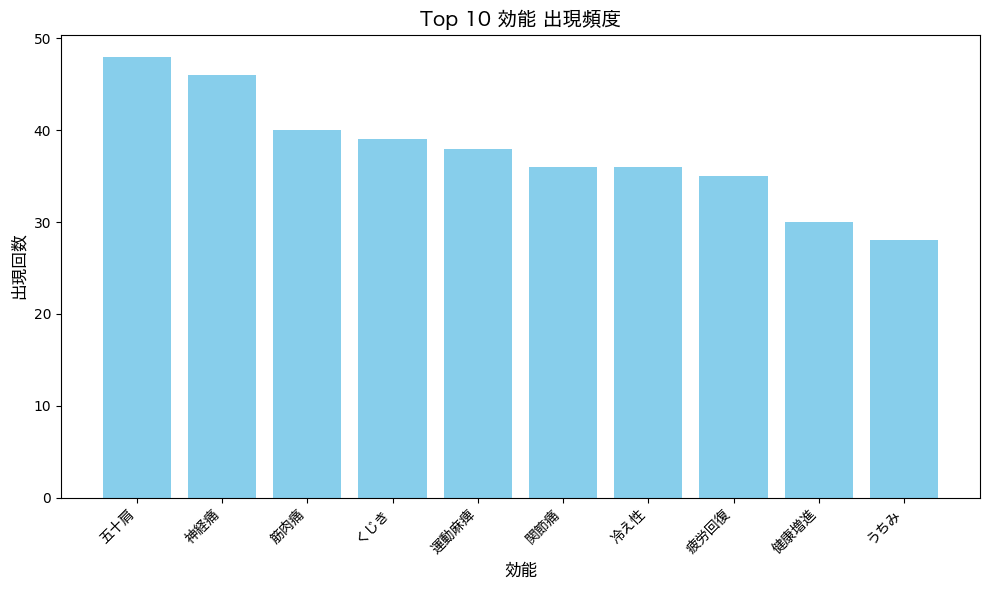

,benefit,count
0,五十肩,48
1,神経痛,46
2,筋肉痛,40
3,くじき,39
4,運動麻痺,38
...,...,...
137,筋肉痛\t 関節痛,1
138,腰痛・ 冷え性・肩こり・しもやけ・うちみ・くじき・ あせも・荒れ性・披露回復\nその他施設サ...,1
139,美肌・疲労回復・リュウマチ・神経痛・やけど皮膚病・婦人病・痔など,1
140,疲労回復など,1


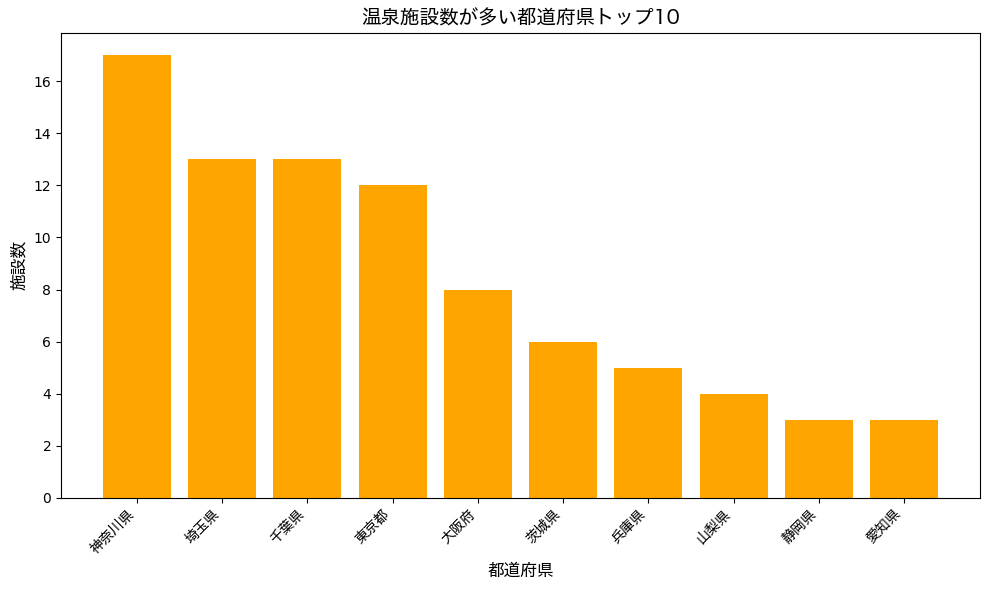

,prefecture,count
0,神奈川県,17
1,埼玉県,13
2,千葉県,13
3,東京都,12
4,大阪府,8
5,茨城県,6
6,兵庫県,5
7,山梨県,4
8,静岡県,3
9,愛知県,3


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.font_manager import FontProperties
import re

# ▼ Mac 環境でヒラギノ角ゴシックW4を指定する例
fp = FontProperties(fname="/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc")

# ---------------------------------
# 1) CSV読み込み
# ---------------------------------
df = pd.read_csv("onsen_details.csv", encoding="utf-8")

# ---------------------------------
# 2) 効能をカウントしてグラフ化
# ---------------------------------
benefit_counter = Counter()

for benefits in df["benefits"]:
    if not isinstance(benefits, str) or benefits == "N/A":
        continue
    # 効能を "、" で分割
    splitted = benefits.split("、")
    splitted = [b.strip() for b in splitted if b.strip()]
    
    benefit_counter.update(splitted)

# 多い順にソート
most_common_benefits = benefit_counter.most_common()

# 上位10件をグラフ表示
top_n = 10
top_benefits = most_common_benefits[:top_n]
benefit_names, benefit_counts = zip(*top_benefits)

plt.figure(figsize=(10, 6))
plt.bar(benefit_names, benefit_counts, color="skyblue")

plt.title(f"Top {top_n} 効能 出現頻度", fontproperties=fp, fontsize=14)
plt.xlabel("効能", fontproperties=fp, fontsize=12)
plt.ylabel("出現回数", fontproperties=fp, fontsize=12)
plt.xticks(rotation=45, ha="right", fontproperties=fp)

plt.tight_layout()
plt.show()

# すべての効能＆カウントをテーブル表示
all_benefits_df = pd.DataFrame(most_common_benefits, columns=["benefit", "count"])
display(all_benefits_df)


# ---------------------------------
# 3) どの都道府県に温泉が多いかを集計
# ---------------------------------

# 都道府県の抜き出し用の簡易関数 (正規表現で「北海道」「東京都」「大阪府」「京都府」 or 「何々県」を拾う)
def parse_prefecture(address: str):
    if not isinstance(address, str):
        return "不明"
    # 北海道のように「道」が含まれない場合
    if address.startswith("北海道"):
        return "北海道"
    
    # 東京都/大阪府/京都府 を含むか、XX県 を含むかを正規表現で検索
    match = re.search(r"(東京都|大阪府|京都府|.{1,3}県)", address)
    if match:
        return match.group(1)
    return "不明"

pref_counter = Counter()

for addr in df["address"]:
    if isinstance(addr, str):
        pref = parse_prefecture(addr)
        if pref != "不明":
            pref_counter[pref] += 1

# 多い順に並べ替え
most_common_pref = pref_counter.most_common()

# 上位10件をグラフ表示
top_n_pref = 10
top_pref = most_common_pref[:top_n_pref]
pref_names, pref_counts = zip(*top_pref)

plt.figure(figsize=(10, 6))
plt.bar(pref_names, pref_counts, color="orange")

plt.title(f"温泉施設数が多い都道府県トップ{top_n_pref}", fontproperties=fp, fontsize=14)
plt.xlabel("都道府県", fontproperties=fp, fontsize=12)
plt.ylabel("施設数", fontproperties=fp, fontsize=12)
plt.xticks(rotation=45, ha="right", fontproperties=fp)

plt.tight_layout()
plt.show()

# すべての都道府県＆施設数をテーブル表示
all_pref_df = pd.DataFrame(most_common_pref, columns=["prefecture", "count"])
display(all_pref_df)